# Autoencoder - Noisy MNIST

In [1]:
!pip install -q tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 35.2MB/s 
     |████████████████████████████████| 450kB 44.2MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.__version__, tf.test.gpu_device_name())
device_lib.list_local_devices()

2.0.0 /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7294896187918397230, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14088031655931028695
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10918755191198980504
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16260613357318221827
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load the data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Play with the data

In [5]:
print('Train data: ', x_train.shape, y_train.shape)
print('Test data: ', x_test.shape, y_test.shape)

Train data:  (60000, 28, 28) (60000,)
Test data:  (10000, 28, 28) (10000,)


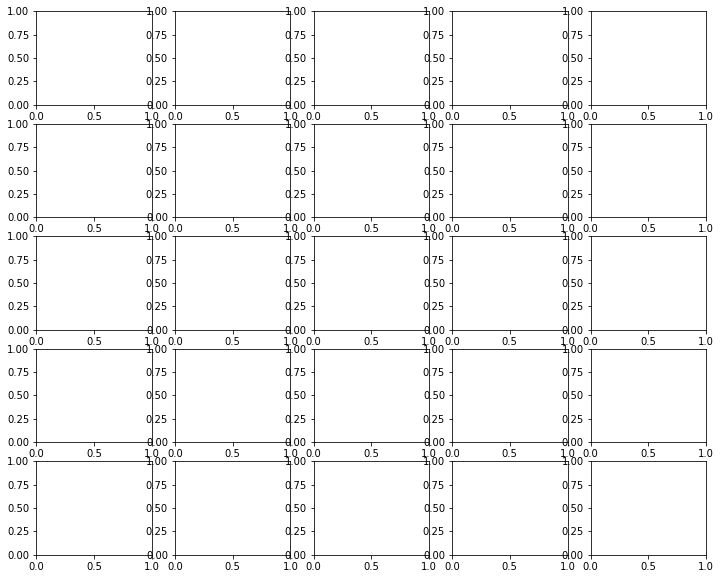

In [6]:
fig1, ax1 = plt.subplots(nrows=5, ncols=5, figsize=(12, 10));

In [0]:
for i in range(5):
		for j in range(5):
			ax1[i, j].axis('off')
			ax1[i, j].grid(False)
			ax1[i, j].set_xticks([])
			ax1[i, j].set_yticks([])

In [0]:
index = 0;
for i in range(5):
    for j in range(5):

        ax1[i, j].imshow(x_train[index], cmap='gray')
        ax1[i, j].set_title(r''.format(y_train[index]), fontsize=8)
        index += 1

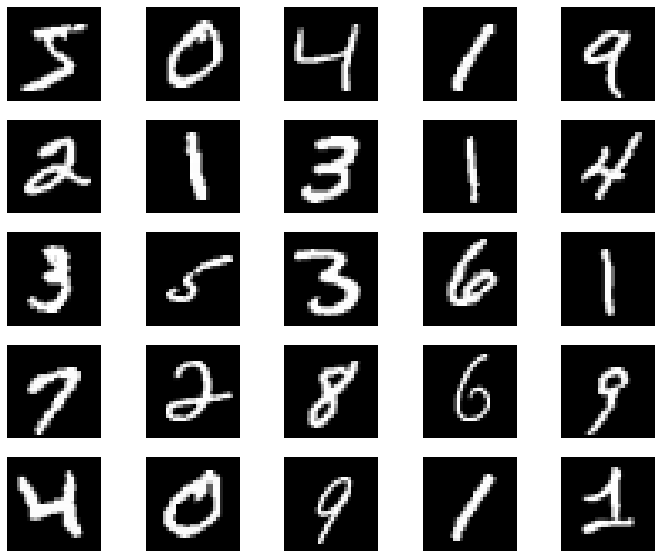

In [9]:
fig1

## Prepare the data

In [0]:
x_train, x_test = x_train/255.0, x_test / 255.0

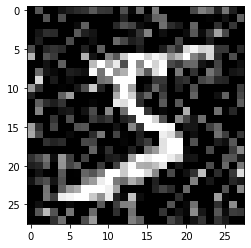

In [11]:
plt.imshow( np.clip(x_train[0] + 0.3*np.random.randn(28,28),0.0,1.0), cmap='gray' )

In [0]:
train_noisy = np.random.randn(*x_train.shape)
test_noisy = np.random.randn(*x_test.shape)

In [0]:
x_train_noisy = np.clip(x_train + 0.3*train_noisy,0.0,1.0)

In [0]:
x_test_noisy = np.clip(x_test + 0.3*test_noisy,0.0,1.0)

In [0]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train_noisy = np.expand_dims(x_train_noisy, -1)
x_test_noisy = np.expand_dims(x_test_noisy, -1)

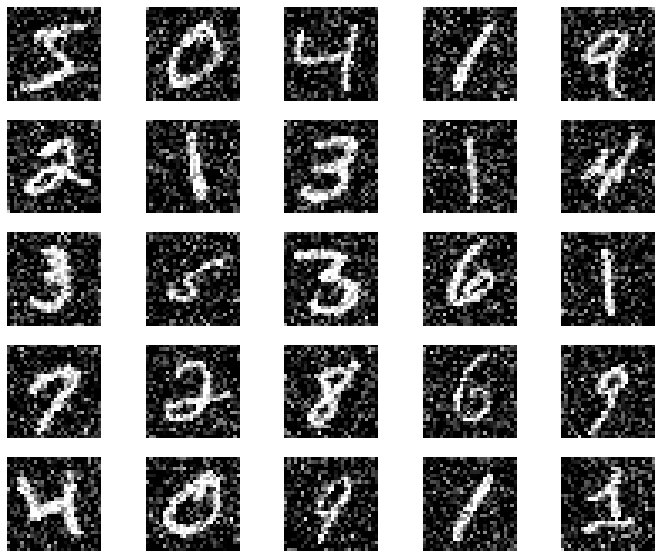

In [16]:
index = 0;
for i in range(5):
    for j in range(5):

        ax1[i, j].imshow(x_train_noisy[index][:,:,0], cmap='gray')
        ax1[i, j].set_title(r''.format(y_train[index]), fontsize=8)
        index += 1
fig1

## Build the model

In [0]:
model = tf.keras.models.Sequential()

In [0]:
# Encoder
model.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding="same", input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding="same"))
model.add(tf.keras.layers.Conv2D(8, (3,3), strides=1, padding="same"))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding="same"))

# Encoded image (code layer)
model.add(tf.keras.layers.Conv2D(8, (3,3), strides=1, padding="same"))

# Decoder
model.add(tf.keras.layers.UpSampling2D((2, 2)))
model.add(tf.keras.layers.Conv2DTranspose(8,(3,3), strides=1, padding="same"))
model.add(tf.keras.layers.UpSampling2D((2, 2)))
model.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=1, activation='sigmoid', padding="same"))


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         5

## Train the model

In [21]:
result = model.fit(x_train_noisy, x_train, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 244us/sample - loss: 0.1287 - accuracy: 0.8094
Epoch 2/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.0985 - accuracy: 0.8137
Epoch 3/10
60000/60000 [==============================] - 12s 192us/sample - loss: 0.0953 - accuracy: 0.8140
Epoch 4/10
60000/60000 [==============================] - 11s 190us/sample - loss: 0.0936 - accuracy: 0.8142
Epoch 5/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.0928 - accuracy: 0.8142
Epoch 6/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.0920 - accuracy: 0.8143
Epoch 7/10
60000/60000 [==============================] - 11s 190us/sample - loss: 0.0912 - accuracy: 0.8143
Epoch 8/10
60000/60000 [==============================] - 12s 195us/sample - loss: 0.0907 - accuracy: 0.8143
Epoch 9/10
60000/60000 [==============================] - 12s 198us/sample - loss: 0.0904 - accuracy: 0.8

## Evaluate the model

In [0]:
x_test_hat = model.predict(x_test_noisy)

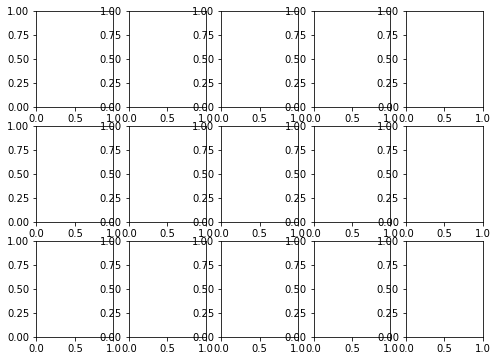

In [23]:
fig2, ax2 = plt.subplots(nrows=3, ncols=5, figsize=(8, 6));

In [0]:
for i in range(3):
		for j in range(5):
			ax2[i, j].axis('off')
			ax2[i, j].grid(False)
			ax2[i, j].set_xticks([])
			ax2[i, j].set_yticks([])

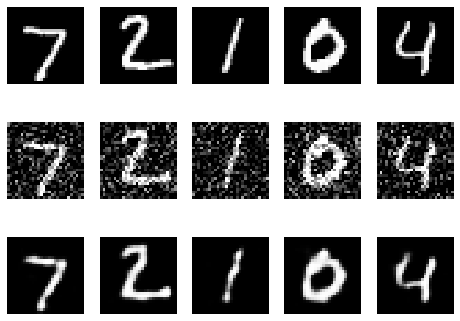

In [25]:
for j in range(5):
        ax2[0, j].imshow(x_test[j][:,:,0], cmap='gray')
        ax2[1, j].imshow(x_test_noisy[j][:,:,0], cmap='gray')
        ax2[2, j].imshow(x_test_hat[j][:,:,0], cmap='gray')
fig2